In [1]:
import sys
sys.path.append("..")
import numpy as np
import json
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from project import data_preprocessing
from project.model import models
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.cluster import KMeans
import pandas as pd
from pandas import DataFrame

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import seaborn as sns 
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.models import load_model
from keras.models import model_from_json

with open('../project/model/saved_model/autoencoder_CV.json','r') as f:
    autoencoder_json = json.load(f)

autoencoder = model_from_json(autoencoder_json)
autoencoder.load_weights('../project/model/saved_model/autoencoder_CV.h5')


with open('../project/model/saved_model/encoder_CV.json','r') as f:
    encoder_json = json.load(f)
    
encoder = model_from_json(encoder_json)
encoder.load_weights('../project/model/saved_model/encoder_CV.h5')


with open('../project/model/saved_model/decoder_CV.json','r') as f:
    decoder_json = json.load(f)

decoder = model_from_json(decoder_json)
decoder.load_weights('../project/model/saved_model/decoder_CV.h5')

Instructions for updating:
Colocations handled automatically by placer.


#### Loading the data

In [3]:
file_path = '../output/universe_repo_cleaned.json'
with open(file_path) as json_file:
    data = json.load(json_file)

In [4]:
universe_indices = list(data.keys())
universe_dividends = []
for index in universe_indices:
    universe_dividends.append(data[index][1])
universe_dividends = np.asarray(universe_dividends)

scaler = MinMaxScaler()
df_train = pd.DataFrame(universe_dividends).T
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train)).T
universe_dividends_normalized = np.asarray(df_train)

In [5]:
universe_dividends_normalized

array([[0.99118052, 1.        , 0.95176849, ..., 0.16702057, 0.08383096,
        0.        ],
       [1.        , 0.97297297, 0.94832195, ..., 0.07198054, 0.03613504,
        0.        ],
       [0.70936716, 0.97700028, 1.        , ..., 0.09791911, 0.03652077,
        0.        ],
       ...,
       [0.88346259, 0.83158667, 1.        , ..., 0.10970367, 0.04805072,
        0.        ],
       [0.99118052, 1.        , 0.95176849, ..., 0.16702057, 0.08383096,
        0.        ],
       [1.        , 0.91597626, 0.80561012, ..., 0.11678131, 0.05867729,
        0.        ]])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 0.4169206730607974)

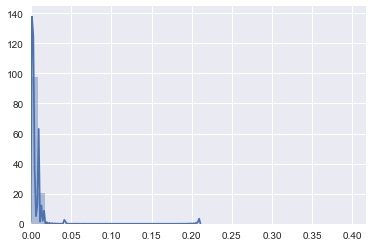

In [6]:
predicted_universe_CV_normalized = autoencoder.predict(universe_dividends_normalized)
predicted_universe_CV = np.asarray(pd.DataFrame(scaler.inverse_transform(pd.DataFrame(predicted_universe_CV_normalized).T)).T)

MSE_CV = []
for i in range(len(universe_dividends)):
    try:
        MSE_CV.append(mean_squared_error(universe_dividends_normalized[i] ,predicted_universe_CV_normalized[i]))
    except:
        MSE_CV.append(0.)
        
sns.distplot(MSE_CV, bins=25)
plt.xlim(0, np.max(MSE_CV)*2)

Pourcentage d'outliers : 0.68%
Indices Of Outliers : [85]
Seuil d'erreur : 0.208


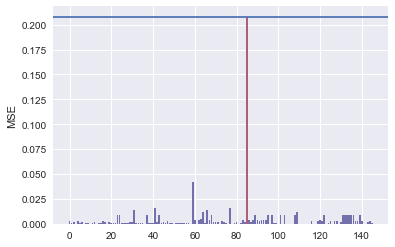

In [7]:
from sklearn.cluster import KMeans

df = pd.DataFrame(MSE_CV)
kmeans = KMeans(n_clusters=2).fit(df)
centroids = kmeans.cluster_centers_
outliers_indices = np.where(kmeans.labels_==0)[0]
if(len(outliers_indices) >= (len(kmeans.labels_)-len(outliers_indices))):
    outliers_indices = np.where(kmeans.labels_==1)[0]
print("Pourcentage d'outliers : " + str(np.around(len(outliers_indices)/len(kmeans.labels_)*100,2)) + "%")
print("Indices Of Outliers : " + str(outliers_indices))
color = []
for i in range(len(kmeans.labels_)):
    if(i in outliers_indices):
        color.append('#B05E77')
    else:
        color.append('#7470AB')

mses = np.round_(MSE_CV,decimals=3)
x = np.arange(0,len(mses))
plt.bar(x, height=mses,color=color)
MSE_outliers = mses[outliers_indices]
seuil = np.min(MSE_outliers)
plt.axhline(seuil)
plt.ylabel('MSE')
print("Seuil d'erreur : " + str(seuil))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 0.4169206730607974)

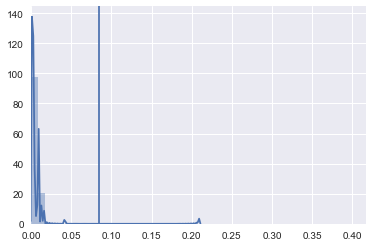

In [9]:
sns.distplot(MSE_CV, bins=25)
plt.axvline(0.085)
plt.xlim(0, np.max(MSE_CV)*2)

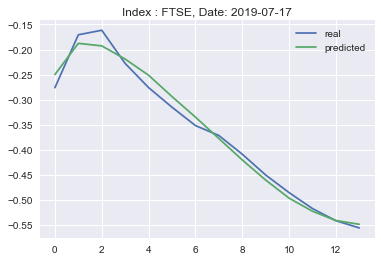

In [12]:
curve_number = 2

plt.plot(universe_dividends[curve_number], label="real")
plt.plot(predicted_universe_CV[curve_number], label="predicted")
plt.legend()
plt.title('Index : {}, Date: {}'.format(list(data.keys())[curve_number], data[list(data.keys())[curve_number]][2]))